###Considering data as continous monthly data with dates


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Epoch 1/50
1/1 - 8s - loss: 0.2762 - 8s/epoch - 8s/step
Epoch 2/50
1/1 - 0s - loss: 0.2290 - 13ms/epoch - 13ms/step
Epoch 3/50
1/1 - 0s - loss: 0.1865 - 14ms/epoch - 14ms/step
Epoch 4/50
1/1 - 0s - loss: 0.1484 - 14ms/epoch - 14ms/step
Epoch 5/50
1/1 - 0s - loss: 0.1147 - 11ms/epoch - 11ms/step
Epoch 6/50
1/1 - 0s - loss: 0.0855 - 11ms/epoch - 11ms/step
Epoch 7/50
1/1 - 0s - loss: 0.0616 - 11ms/epoch - 11ms/step
Epoch 8/50
1/1 - 0s - loss: 0.0443 - 11ms/epoch - 11ms/step
Epoch 9/50
1/1 - 0s - loss: 0.0358 - 13ms/epoch - 13ms/step
Epoch 10/50
1/1 - 0s - loss: 0.0386 - 11ms/epoch - 11ms/step
Epoch 11/50
1/1 - 0s - loss: 0.0498 - 11ms/epoch - 11ms/step
Epoch 12/50
1/1 - 0s - loss: 0.0580 - 11ms/epoch - 11ms/step
Epoch 13/50
1/1 - 0s - loss: 0.0578 - 13ms/epoch - 13ms/step
Epoch 14/50
1/1 - 0s - loss: 0.0522 - 11ms/epoch - 11ms/step
Epoch 15/50
1/1 - 0s - loss: 0.0454 - 12ms/epoch - 12ms/step
Epoch 16/50
1/1 - 0s - loss: 0.0399 - 11ms/epoch - 11ms/step
Epoch 17/50
1/1 - 0s - loss: 0.0364 -

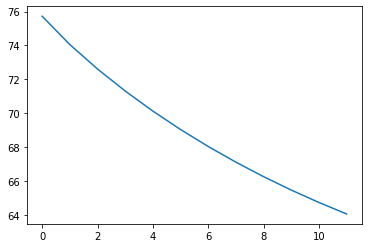

In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# load data
df = pd.read_csv('/content/AQI_data.csv')
df['date'] = pd.to_datetime(df.date, format='%d-%m-%Y')
df['date']=df.date.dt.strftime('%Y/%d/%m')
df = df.set_index('date')

# preprocess data
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df)

# split data into training and test sets
train_size = int(len(df_scaled) * 0.8)
train, test = df_scaled[:train_size, :], df_scaled[train_size:, :]

# create sequences for LSTM model
def create_sequences(dataset, seq_length):
    X, y = [], []
    for i in range(len(dataset) - seq_length):
        X.append(dataset[i:i+seq_length, :])
        y.append(dataset[i+seq_length, 0])
    return np.array(X), np.array(y)

seq_length = 60 # use 60 monthly time steps as input for LSTM
train_X, train_y = create_sequences(train, seq_length)
test_X, test_y = create_sequences(test, seq_length)

# define LSTM model
model = Sequential()
model.add(LSTM(64, input_shape=(seq_length, train.shape[1])))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')

# train LSTM model
model.fit(train_X, train_y, epochs=50, batch_size=16, verbose=2)

# use LSTM model to forecast AQI for 2023
num_forecasts = 12 # forecast for 12 months in 2023
forecast_X = np.empty((num_forecasts, seq_length, train.shape[1]))
last_train_seq = train_X[-1] # last sequence in training set
forecast_X[0] = last_train_seq # first input for forecasting
for i in range(1, num_forecasts):
    last_seq_pred = model.predict(np.array([last_train_seq]))[0][0] # predict next value based on last sequence
    last_train_seq = np.append(last_train_seq[1:], [[last_seq_pred]], axis=0) # add predicted value to sequence
    forecast_X[i] = last_train_seq # add sequence to input for forecasting

# forecast = scaler.inverse_transform(np.concatenate((df[-12:].values, forecast), axis=0))
forecast = model.predict(forecast_X)
forecast = scaler.inverse_transform(forecast)


# plot actual vs forecasted AQI values
import matplotlib.pyplot as plt
plt.plot(list(forecast))
plt.show()